<a href="https://colab.research.google.com/github/LeSaUi/DLtest/blob/main/TransferLearningforComputerVisionTutorialExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision torchaudio torchdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install matplotlib numpy pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# License : BSD
# Author : Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() # interactive mode

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-04-27 11:39:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.39.6, 18.65.39.56, 18.65.39.75, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.39.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   119MB/s    in 0.4s    

2023-04-27 11:39:22 (119 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]



In [8]:
!ls
!mkdir data
!cd data
!mv ../hymenoptera_data.zip .
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [13]:
%cd ..

/content


In [23]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


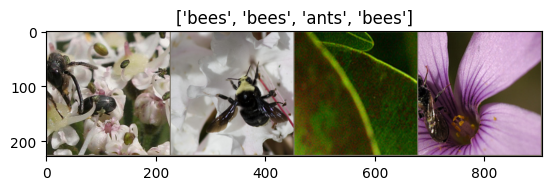

In [16]:
def imshow(inp, title=None):
  """Display image for Tnesor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a tranining and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      
      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
    print()

  time_elapsed = time.time() - since
  print(f'Traninig complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [25]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
      model.train(mode=was_training)

In [26]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ''nn.Linear(num_ftrs, len(class_names))''.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6592 Acc: 0.7008
val Loss: 0.3657 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.5955 Acc: 0.7377
val Loss: 0.1994 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4715 Acc: 0.7828
val Loss: 0.2077 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.5817 Acc: 0.7869
val Loss: 0.2152 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5121 Acc: 0.7787
val Loss: 0.2965 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.6246 Acc: 0.7746
val Loss: 0.3916 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5392 Acc: 0.8115
val Loss: 0.5636 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4686 Acc: 0.8156
val Loss: 0.2841 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3590 Acc: 0.8361
val Loss: 0.1975 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3163 Acc: 0.8730
val Loss: 0.2057 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3784 Acc: 0.8279
val Loss: 0.2325 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3149 Acc: 0.8934
val Loss: 0.1964 Acc: 0.9281

Ep

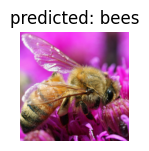

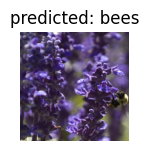

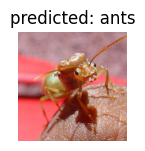

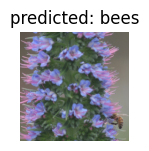

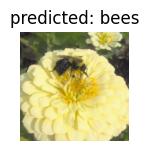

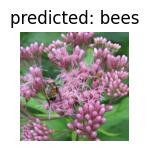

In [28]:
visualize_model(model_ft)

In [29]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly contructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5535 Acc: 0.7131
val Loss: 0.2415 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5073 Acc: 0.7746
val Loss: 0.2125 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3929 Acc: 0.8238
val Loss: 0.2350 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3765 Acc: 0.8238
val Loss: 0.1828 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4843 Acc: 0.7951
val Loss: 0.2053 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.6162 Acc: 0.7582
val Loss: 0.2529 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4532 Acc: 0.8033
val Loss: 0.2336 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4935 Acc: 0.7746
val Loss: 0.2104 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4324 Acc: 0.8320
val Loss: 0.1985 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3642 Acc: 0.8402
val Loss: 0.1945 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3410 Acc: 0.8566
val Loss: 0.2192 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4174 Acc: 0.8156
val Loss: 0.2056 Acc: 0.9346

Ep

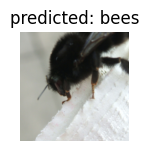

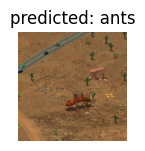

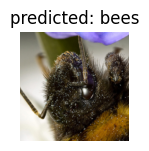

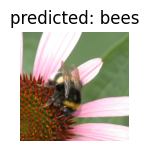

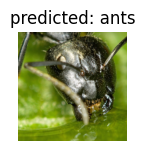

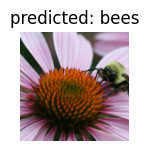

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()